# **Installs**

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00a 0:00:01


# **Imports**

In [ ]:
# Basic Libraries
import enum
import numpy as np
import matplotlib.pyplot as plt

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models

# PIL and Image Processing
from PIL import Image
from skimage.transform import resize
from skimage.metrics import structural_similarity, mean_squared_error, peak_signal_noise_ratio

# Keras for Image Preprocessing
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

# Captum for Model Interpretability
from captum.attr import IntegratedGradients, Saliency


# **Utills**

In [ ]:
class LRPRule(enum.Enum):
    z_plus = 0
    z_b = 1
    alpha_beta = 2
    alpha_beta_bias = 3


class ExplainingMethod(enum.Enum):
    lrp = 0
    gradient = 1
    guided_backprop = 2
    integrated_grad = 3
    pattern_attribution = 4
    grad_times_input = 5

# **Model**

In [ ]:
# Define the PyTorch Model class with ResNet50
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights='DEFAULT')  # Use 'weights' instead of 'pretrained'
        self.model.eval()
        self.input_size = (224, 224)

    def forward(self, x):
        return self.model(x)

    def classify(self, x):
        with torch.no_grad():
            preds = self.forward(x)
            class_idx = torch.argmax(preds, dim=1)
        return preds, class_idx

# **RISE**

In [ ]:
# Generate RISE masks
def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s).astype(int)
    up_size = (s + 1) * cell_size
    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')
    masks = np.empty((N, *input_size))
    for i in range(N):
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        resized_mask = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=False)
        masks[i, :, :] = resized_mask[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks

# Apply RISE for saliency maps
def explain(model, inp, masks, N, batch_size, p1):
    model.eval()
    preds = []
    inp = torch.tensor(np.copy(inp), dtype=torch.float32).to(device)
    masks = torch.tensor(np.copy(masks), dtype=torch.float32).to(device)
    masked = inp * masks
    with torch.no_grad():
        for i in range(0, N, batch_size):
            batch = masked[i:min(i + batch_size, N)]
            batch = batch.permute(0, 3, 1, 2)  # Convert from (B, H, W, C) to (B, C, H, W)
            preds_batch = model(batch).cpu().numpy()
            preds.append(preds_batch)
    preds = np.concatenate(preds)
    masks_np = masks.cpu().numpy()
    sal = preds.T.dot(masks_np.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1

    # If `sal` has more than one channel or dimension, average over them
    if sal.ndim == 4:  # Check if the saliency map has more than one channel
        sal = np.mean(sal, axis=0)  # Average across channels or samples
    elif sal.ndim == 3:
        sal = np.mean(sal, axis=0)  # Average if saliency maps are stacked

    return sal

# **Image Loading and Preprocessing**

In [ ]:
# Load and preprocess image
def load_img(path, model):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script
# Initialize model
model = Model().to(device)

# Load image and preprocess
img, x = load_img('/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000038.jpg', model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s] 


# **Plotting saliency map**

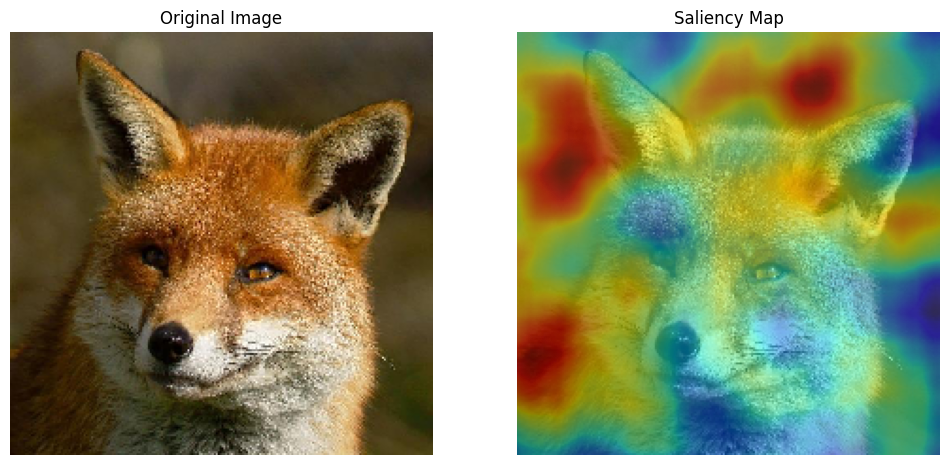

In [ ]:
# Generate RISE masks
masks = generate_masks(2000, 8, 0.5, model.input_size)

# Apply RISE for saliency maps
sal = explain(model, x, masks, 2000, 32, 0.5)

# Convert saliency map to correct format for display
sal = np.squeeze(sal)  # Remove single-dimensional entries from the shape

# Ensure sal is within the range [0, 1] for display
sal = np.clip(sal, 0, 1)

# Plotting
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Saliency Map
plt.subplot(1, 2, 2)
plt.imshow(img)  # Display original image as background
plt.imshow(sal, cmap='jet', alpha=0.5)  # Overlay saliency map
plt.title('Saliency Map')
plt.axis('off')

plt.show()

# **Adversarial attack**

In [ ]:
#Helper method to get the heatmap using Captum
def get_expl(model, x, method, desired_index=None):
    """
    Helper method to get the heatmap using Captum with a PyTorch model.
    """
    x = x.to(device)  # Ensure x is on the correct device
    x.requires_grad = True

    if method == 'integrated_gradients':
        ig = IntegratedGradients(model)
        if desired_index is None:
            preds = model(x)
            desired_index = preds.argmax().item()
        attributions, delta = ig.attribute(x, target=desired_index, return_convergence_delta=True)
        heatmap = attributions.sum(dim=1).cpu().detach()
    elif method == 'saliency':
        saliency = Saliency(model)
        if desired_index is None:
            preds = model(x)
            desired_index = preds.argmax().item()
        attributions = saliency.attribute(x, target=desired_index)
        heatmap = attributions.sum(dim=1).cpu().detach()
    else:
        raise NotImplementedError(f"Explanation method '{method}' is not implemented")

    heatmap = torch.sum(torch.abs(heatmap), dim=1)
    normalized_heatmap = heatmap / torch.sum(heatmap)

    if 'preds' not in locals():
        preds = model(x)
        desired_index = preds.argmax().item()

    return normalized_heatmap, preds, desired_index

# Define a clamp function
def clamp(tensor, mean, std):
    return torch.clamp(tensor, mean - 3 * std, mean + 3 * std)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example hyperparameters
lr = 0.01  # Learning rate for the optimizer
num_iter = 100  # Number of iterations for the adversarial attack
exp_method = 'integrated_gradients'  # Choose between 'integrated_gradients' and 'saliency'

# Initialize model
model = Model().to(device)  # Ensure you have your Model class defined

# Example data preparation
def preprocess_input(x_np):
    x_np = np.transpose(x_np, (0, 3, 1, 2))  # Convert to [batch_size, channels, height, width]
    x_tensor = torch.tensor(x_np, dtype=torch.float32).to(device)
    return x_tensor

# Create a dummy input tensor
x_np = np.random.rand(1, 224, 224, 3)  # Single RGB image
x_tensor = preprocess_input(x_np)

# Ensure x_tensor has gradients enabled
x_adv = x_tensor.clone().detach().requires_grad_(True)

# Get the original explanation and index
org_expl, org_acc, org_idx = get_expl(model, x_tensor, exp_method)
org_idx = org_idx  # Directly use the index

# Define target matrix and prefactors for loss computation
target_mtx_torch = torch.zeros_like(org_expl, requires_grad=False)  # Example, adjust according to your use case
prefactors = [1.0, 1.0]  # Example, adjust according to your use case
prediction_class = org_idx

# Example data mean and std for clamping
data_mean = 0.485
data_std =  0.459
# # load model
# data_mean = np.array([0.485, 0.456, 0.406])
# data_std = np.array([0.229, 0.224, 0.225])

# Prepare optimizer
optimizer = optim.Adam([x_adv], lr=lr)

# Perform adversarial attack
for i in range(num_iter):
    optimizer.zero_grad()  # Zero the gradients before the backward pass

    # Compute the explanation and predictions for the adversarial example
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, exp_method, desired_index=org_idx)

    # Compute the losses
    loss_center = F.mse_loss(adv_expl, target_mtx_torch)
    loss_output = F.mse_loss(adv_acc[0][prediction_class], org_acc[0][prediction_class])
    total_loss = prefactors[0] * loss_output + prefactors[1] * loss_center

#     # Print losses for debugging
#     print(f"Iteration {i + 1}/{num_iter}")
#     print(f"Loss Center: {loss_center.item():.4f}")
#     print(f"Loss Output: {loss_output.item():.4f}")
#     print(f"Total Loss: {total_loss.item():.4f}")

    # Ensure that x_adv requires gradients
    if not x_adv.requires_grad:
        print("Warning: x_adv does not require gradients. Setting requires_grad=True.")
        x_adv.requires_grad_(True)

    # Perform backward pass to compute gradients
    total_loss.backward(retain_graph=True)  # Retain the graph if multiple backward passes are needed

#     # Check gradients to ensure they are being computed
#     if x_adv.grad is None:
#         print("Warning: x_adv does not have gradients after backward pass.")
#     else:
#         print(f"Max gradient value: {x_adv.grad.max().item():.4f}")
#         print(f"Min gradient value: {x_adv.grad.min().item():.4f}")

    # Update the adversarial example
    optimizer.step()  # Apply gradients to update x_adv

    # Apply clamping to keep the adversarial example within a valid range
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    # Optionally print updated adversarial example statistics
#     print(f"Updated x_adv range: min={x_adv.data.min().item():.4f}, max={x_adv.data.max().item():.4f}")

# Ensure x_adv is moved back to the CPU and converted to a NumPy array if needed
x_adv_numpy = x_adv.cpu().detach().numpy()
print("Adversarial attack completed.")


Adversarial attack completed.


In [ ]:
target_mtx = torch.zeros_like(org_expl[0])

# Convert saliency maps and target matrix to numpy arrays
adv_expl_np = adv_expl[0].cpu().detach().numpy()
org_expl_np = org_expl[0].cpu().detach().numpy()
target_mtx_flat = target_mtx.flatten()
target_mtx_np = target_mtx_flat.cpu().detach().numpy()  # Ensure target_mtx is also converted to numpy array

# Handle 1D arrays
if len(adv_expl_np.shape) == 1:
    # Reshape target_mtx_np to match other arrays
    target_mtx_np = target_mtx_np.reshape(-1)
elif len(target_mtx_np.shape) == 2:
    # Flatten target_mtx_np if it's 2D with 1 row
    if target_mtx_np.shape[0] == 1:
        target_mtx_np = target_mtx_np.flatten()
    else:
        raise ValueError("Target matrix shape is incompatible for comparison.")

# # Print the shapes to debug
# print("Shape of Original Explanation:", org_expl_np.shape)
# print("Shape of Adversarial Explanation:", adv_expl_np.shape)
# print("Shape of Target Matrix:", target_mtx_np.shape)

# Ensure all matrices have the same dimensions for comparison
if adv_expl_np.shape != org_expl_np.shape or adv_expl_np.shape != target_mtx_np.shape:
    raise ValueError('Input matrices must have the same dimensions.')

# Determine the data range for floating-point images
data_range = adv_expl_np.max() - adv_expl_np.min()  # Assuming the range is the same for all images

# Compare saliency maps
print('SSIM:')
print('Original and Adversarial:', structural_similarity(org_expl_np, adv_expl_np, multichannel=False, data_range=data_range))
print('Original and Target:', structural_similarity(org_expl_np, target_mtx_np, multichannel=False, data_range=data_range))
print('Adversarial and Target:', structural_similarity(adv_expl_np, target_mtx_np, multichannel=False, data_range=data_range))

print('MSE:')
print('Original and Adversarial:', mean_squared_error(org_expl_np, adv_expl_np))
print('Original and Target:', mean_squared_error(org_expl_np, target_mtx_np))
print('Adversarial and Target:', mean_squared_error(adv_expl_np, target_mtx_np))

print('PSNR:')
print('Original and Adversarial:', peak_signal_noise_ratio(org_expl_np, adv_expl_np, data_range=data_range))
print('Original and Target:', peak_signal_noise_ratio(org_expl_np, target_mtx_np, data_range=data_range))
print('Adversarial and Target:', peak_signal_noise_ratio(adv_expl_np, target_mtx_np, data_range=data_range))


SSIM:
Original and Adversarial: 0.9999999999997815
Original and Target: 5.090057798990618e-05
Adversarial and Target: 5.0900576949546796e-05
MSE:
Original and Adversarial: 1.3635088172286404e-20
Original and Target: 2.140816307046526e-05
Adversarial and Target: 2.1408163046164856e-05
PSNR:
Original and Adversarial: 154.37964245164667
Original and Target: 2.4204279163572906
Adversarial and Target: 2.420427921286966


# **Explanation**

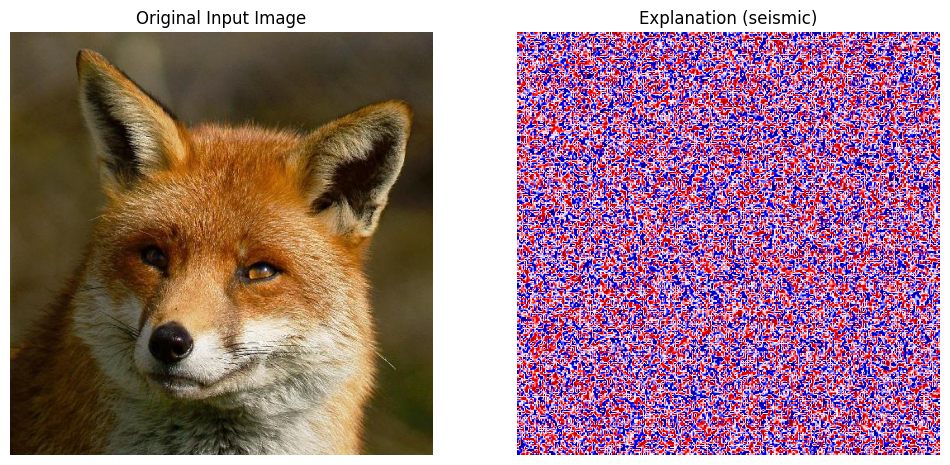

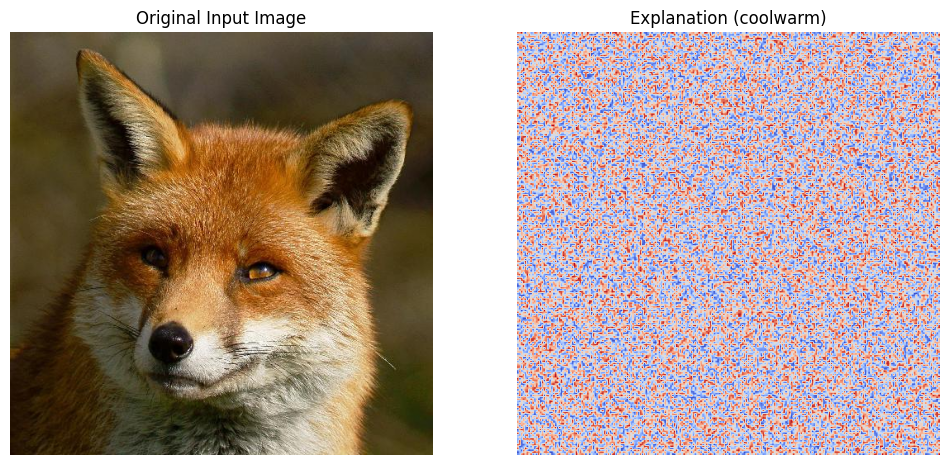

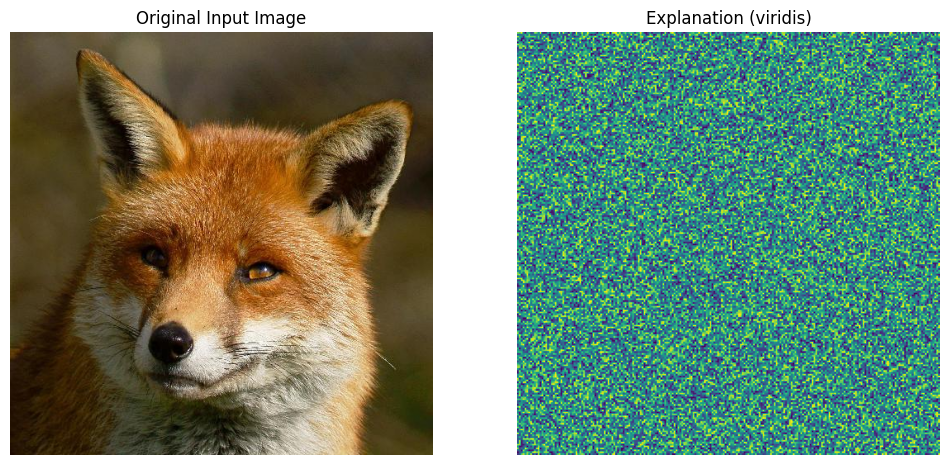

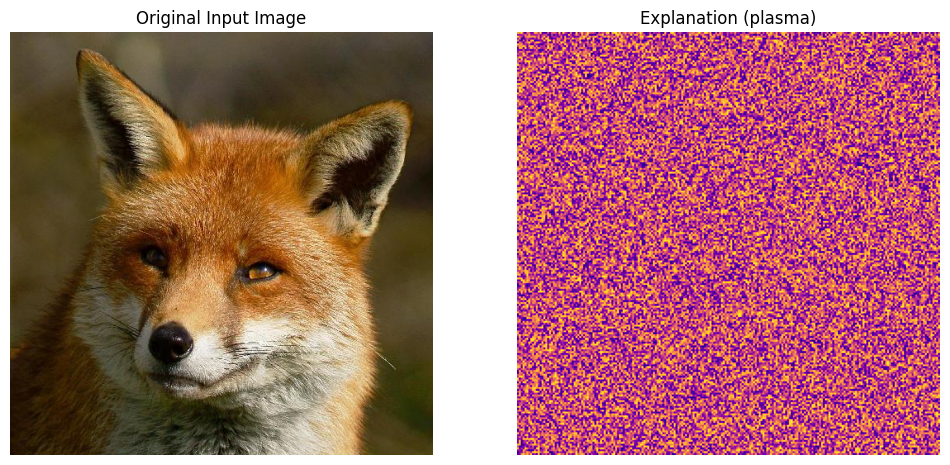

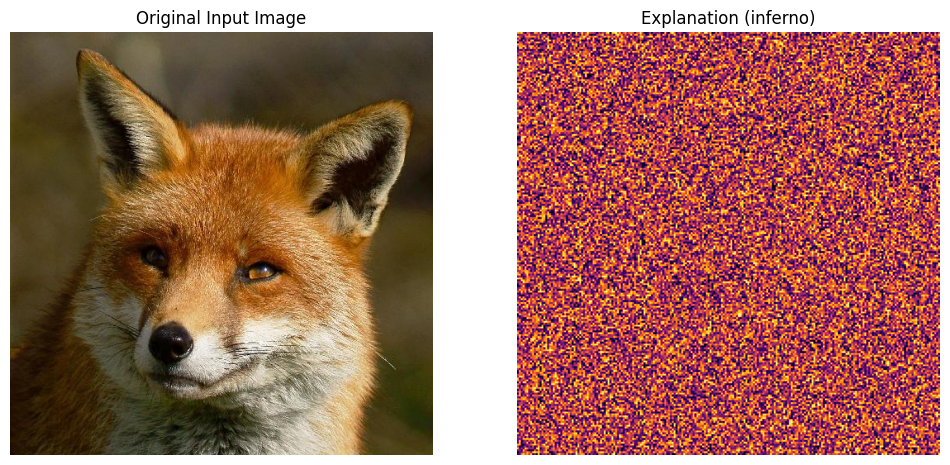

In [ ]:
def heatmap_to_image(heatmap):
    """
    Convert a heatmap to a normalized image format.

    Args:
        heatmap (np.ndarray or torch.Tensor): The heatmap array to convert.

    Returns:
        np.ndarray: The converted image.
    """
    # Ensure heatmap is a tensor, if not convert it to numpy array
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().detach().numpy()

    # Ensure heatmap is a 2D array
    if len(heatmap.shape) == 1:
        side_length = int(np.sqrt(heatmap.size))
        heatmap = heatmap.reshape(side_length, side_length)

    # Normalize the heatmap to the range [0, 1]
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    return heatmap

def plot_comparison(original_image, explanation, colormap='seismic', title_original='Original Image', title_explanation='Explanation'):
    """
    Plot the original image and its corresponding explanation side by side using the specified colormap.

    Args:
        original_image (np.ndarray): The original image to display.
        explanation (np.ndarray or torch.Tensor): The explanation heatmap to display.
        colormap (str): Colormap to use for the explanation plot.
        title_original (str): Title for the original image plot.
        title_explanation (str): Title for the explanation plot.
    """
    # Convert heatmap to image
    explanation_image = heatmap_to_image(explanation)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original Image
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title(title_original)

    # Explanation Image
    axes[1].imshow(explanation_image, cmap=colormap, norm=plt.Normalize(vmin=0, vmax=1))
    axes[1].axis('off')
    axes[1].set_title(title_explanation)

    plt.show()

# Load the original image using PIL and convert it to a NumPy array
original_image_path = '/kaggle/input/animal-faces/afhq/val/wild/flickr_wild_000038.jpg'
original_image_pil = Image.open(original_image_path)
original_image = np.array(original_image_pil)

# Convert the image to HWC format if necessary
if original_image.shape[2] == 3:
    # Already in HWC format
    pass
else:
    original_image = np.transpose(original_image, (1, 2, 0))

# Example explanation heatmap (for demonstration, replace with actual heatmap)
org_expl = np.random.rand(224, 224)  # Dummy heatmap for example

# List of colormaps to use
colormaps = ['seismic', 'coolwarm', 'viridis', 'plasma', 'inferno']

# Plot comparisons with different colormaps
for cmap in colormaps:
    plot_comparison(original_image, org_expl, colormap=cmap, title_original='Original Input Image', title_explanation=f'Explanation ({cmap})')


In [ ]:
org_expl


array([[0.84078643, 0.77636851, 0.99950454, ..., 0.63875876, 0.12106554,
        0.57287972],
       [0.27952602, 0.31218798, 0.32956293, ..., 0.94659406, 0.43624867,
        0.99981227],
       [0.91290404, 0.5758213 , 0.51319448, ..., 0.49130221, 0.59916886,
        0.7085813 ],
       ...,
       [0.29163545, 0.37707179, 0.03091329, ..., 0.65902214, 0.95405768,
        0.21426714],
       [0.01617722, 0.26930609, 0.2712763 , ..., 0.4150598 , 0.51584855,
        0.58304036],
       [0.16350554, 0.2670106 , 0.77323929, ..., 0.65030339, 0.11826939,
        0.99736558]])

# **Plotting Adversarial Saliency Map**

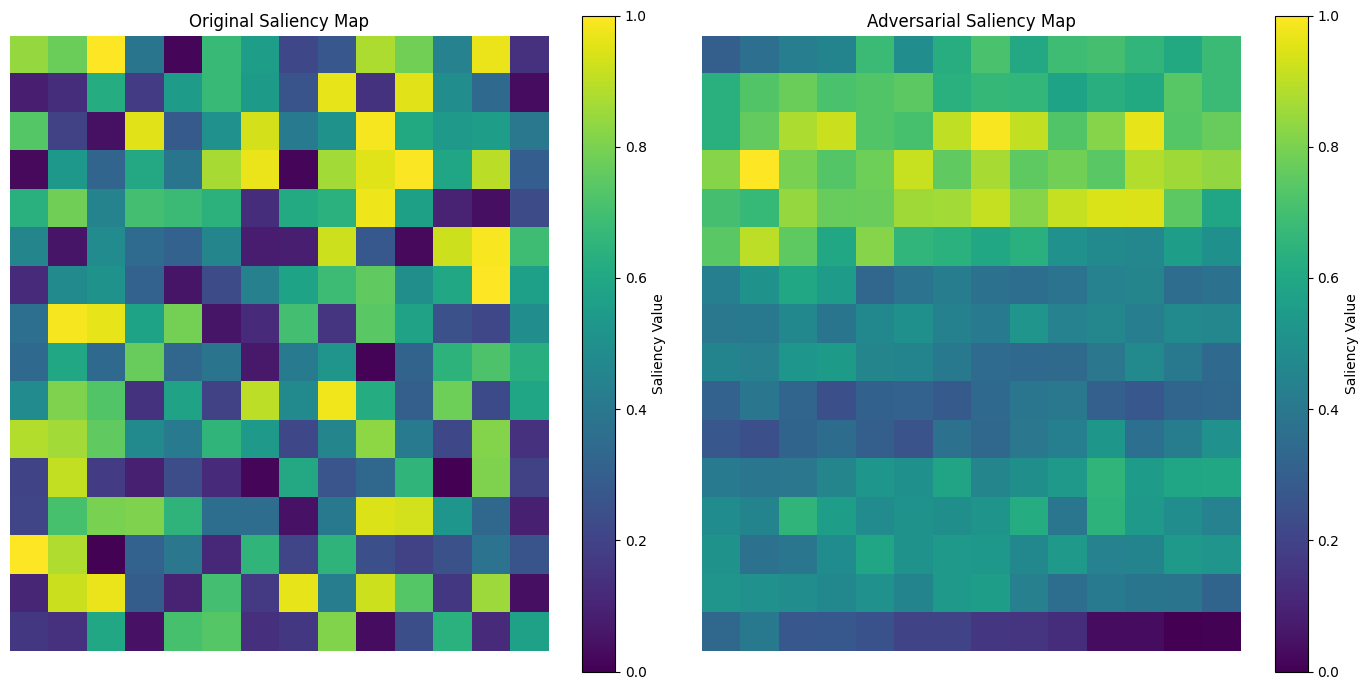

In [ ]:
import torch  # Make sure to import torch
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
def to_numpy(arr):
    if torch.is_tensor(arr):
        return arr.cpu().detach().numpy()
    return arr  # It's already a NumPy array

# Apply conversion
adv_expl_np = to_numpy(adv_expl[0])
org_expl_np = to_numpy(org_expl[0])

# Reshape to 2D (e.g., (16, 14)) if they are 1D
def reshape_for_display(arr, target_shape=(16, 14)):
    if arr.ndim == 1:
        return arr.reshape(target_shape)
    return arr

# Replace with the appropriate shape if necessary
adv_expl_np = reshape_for_display(adv_expl_np, target_shape=(16, 14))
org_expl_np = reshape_for_display(org_expl_np, target_shape=(16, 14))

# Normalize data (optional, but recommended for saliency maps)
adv_expl_np = (adv_expl_np - adv_expl_np.min()) / (adv_expl_np.max() - adv_expl_np.min())
org_expl_np = (org_expl_np - org_expl_np.min()) / (org_expl_np.max() - org_expl_np.min())

# Plot the saliency maps
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the original saliency map
im1 = axes[0].imshow(org_expl_np, cmap='viridis', interpolation='none', norm=plt.Normalize(vmin=0, vmax=1))
axes[0].set_title('Original Saliency Map')
axes[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Saliency Value')

# Plot the adversarial saliency map
im2 = axes[1].imshow(adv_expl_np, cmap='viridis', interpolation='none', norm=plt.Normalize(vmin=0, vmax=1))
axes[1].set_title('Adversarial Saliency Map')
axes[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Saliency Value')

plt.tight_layout()
plt.show()
